##Importacion de librerias

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import os

##Procesamiento de las imagenes

In [ ]:
# Ruta del dataset
base_dir = 'Dataset'

# Categorías seleccionadas
categories = ['car', 'face', 'tree', 'dog', 'teddy']

# Función para obtener las imágenes por categoría
def get_images_by_category(base_dir, categories):
    images = {category: [] for category in categories}
    for category in categories:
        category_path = Path(base_dir) / category
        if category_path.exists():
            images[category] = list(category_path.glob('*.png'))  # Ajustar si el formato cambia
        else:
            print(f"Advertencia: No se encontró la categoría {category}")
    return images

# Función para extraer la firma de forma (Fourier Descriptors)
def extract_shape_signature(image_path):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) == 0:
        return None

    cnt = max(contours, key=cv2.contourArea)
    cnt = cnt.squeeze()
    if len(cnt.shape) != 2:
        return None

    complex_contour = np.empty(cnt.shape[0], dtype=complex)
    complex_contour.real = cnt[:, 0]
    complex_contour.imag = cnt[:, 1]

    fourier_result = np.fft.fft(complex_contour)
    return np.abs(fourier_result[:20])  # Tomamos los primeros 20 coeficientes

# Función para calcular la distancia euclidiana
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# Función para clasificar una imagen comparando su firma de forma
def classify_image(test_image_path, category_signatures):
    test_signature = extract_shape_signature(test_image_path)

    if test_signature is None:
        return "No se pudo extraer la firma de forma"

    # Comparar la firma de forma de la imagen de prueba con las firmas promedio de cada categoría
    min_distance = float('inf')
    predicted_category = None
    for category, signature in category_signatures.items():
        distance = euclidean_distance(test_signature, signature)
        if distance < min_distance:
            min_distance = distance
            predicted_category = category

    return predicted_category

# Paso 1: Obtener las imágenes filtradas
images = get_images_by_category(base_dir, categories)

# Paso 2: Extraer la firma de forma promedio por categoría (para "entrenar")
category_signatures = {}
for category, image_list in images.items():
    signatures = []
    for img_path in image_list:
        signature = extract_shape_signature(img_path)
        if signature is not None:
            signatures.append(signature)

    if signatures:
        # Promediar las firmas de forma para la categoría
        category_signatures[category] = np.mean(signatures, axis=0)

# Paso 3: Clasificar las imágenes de prueba
correct_predictions = 0
total_predictions = 0

# Probar con las imágenes de prueba (las mismas imágenes del conjunto de entrenamiento, en este caso)
for category, image_list in images.items():
    for img_path in image_list:
        predicted_category = classify_image(img_path, category_signatures)

        if predicted_category == category:
            correct_predictions += 1
        total_predictions += 1

# Calcular precisión
accuracy = correct_predictions / total_predictions
print(f"Precisión total: {accuracy:.2f}")


Precisión total: 0.80


##Imagenes en las que se confunde

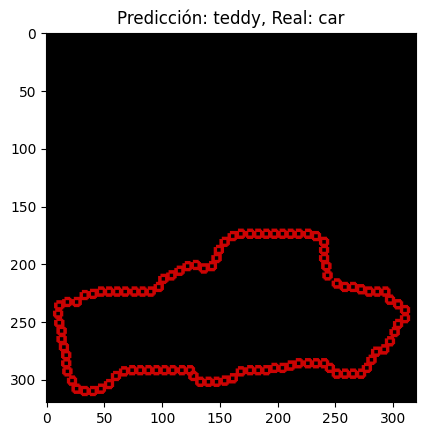

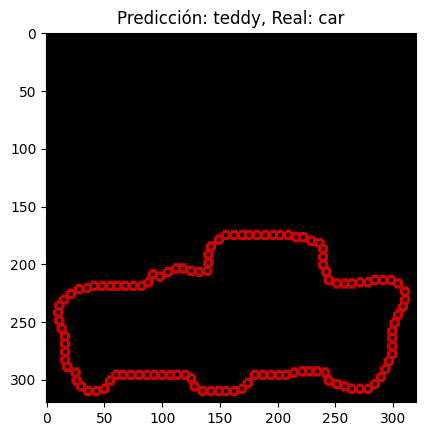

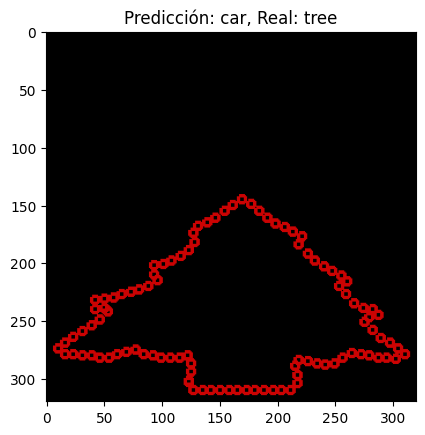

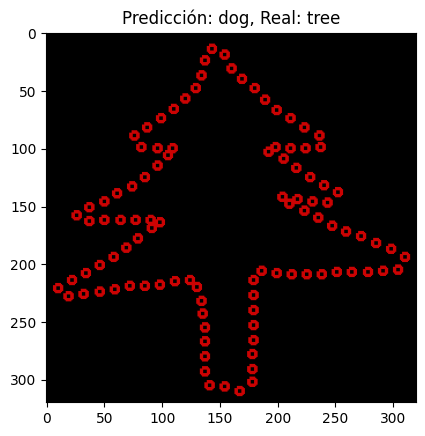

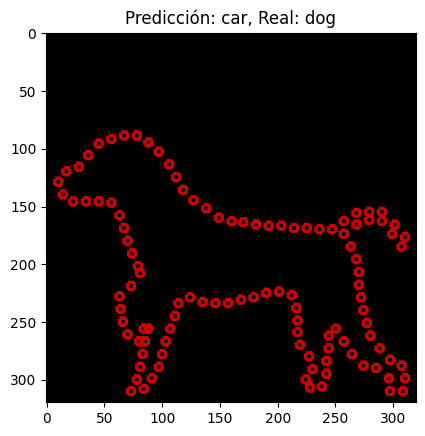

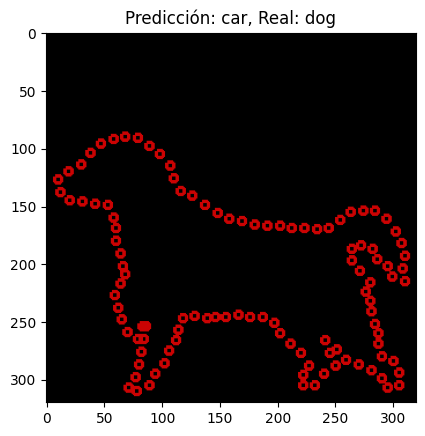

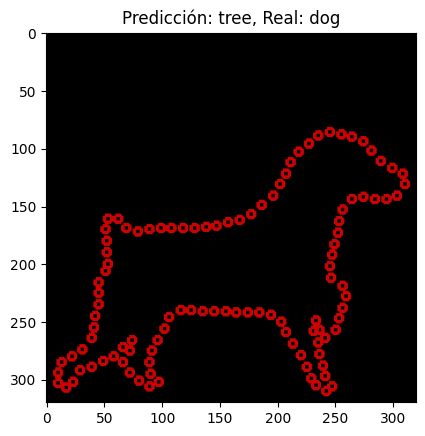

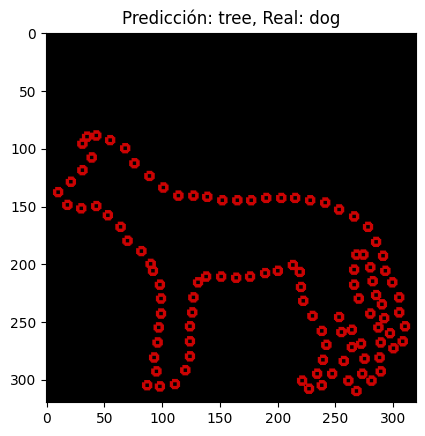

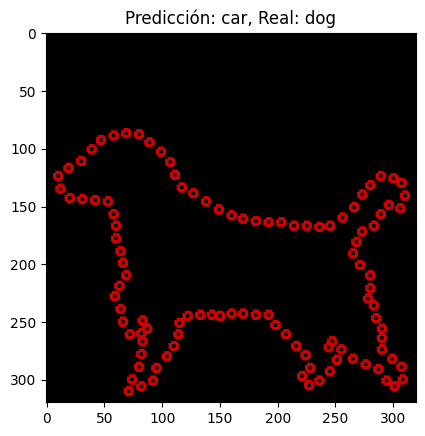

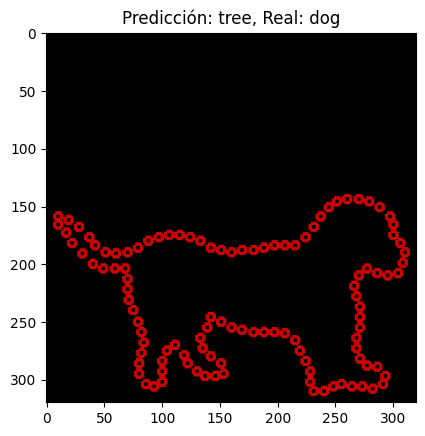

In [ ]:
import matplotlib.pyplot as plt

for category, image_list in images.items():
    for img_path in image_list:
        predicted_category = classify_image(img_path, category_signatures)
        if predicted_category != category:
            img = cv2.imread(str(img_path))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Predicción: {predicted_category}, Real: {category}")
            plt.show()


##Matriz de confusion

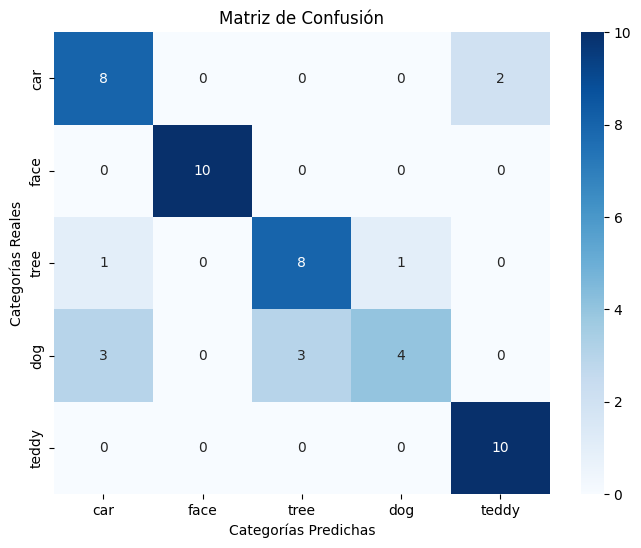

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Suponiendo que 'y_true' y 'y_pred' ya están definidos
y_true = []
y_pred = []

# Obtener las imágenes y clasificarlas
for category, image_list in images.items():
    for img_path in image_list:
        predicted_category = classify_image(img_path, category_signatures)
        y_true.append(category)
        y_pred.append(predicted_category)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=categories)

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Categorías Predichas')
plt.ylabel('Categorías Reales')
plt.title('Matriz de Confusión')
plt.show()
